## Week 2 - Solving a 3x3 using Grover's Algorithm

In [19]:
import numpy as np
from sympy import Matrix
from qiskit import IBMQ, QuantumCircuit, Aer, execute, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

ibmqfactory.load_account:WARNING:2020-11-19 03:34:16,430: Credentials are already in use. The existing account in the session will be replaced.


## Clasically Solving the Problem (For Solution Checks Only)

In [10]:
matrix = np.array([[1,1,0,1,0,0,0,0,0],[1,1,1,0,1,0,0,0,0],[0,1,1,0,0,1,0,0,0],[1,0,0,1,1,0,1,0,0],[0,1,0,1,1,1,0,1,0],[0,0,1,0,1,1,0,0,1],[0,0,0,1,0,0,1,1,0],[0,0,0,0,1,0,1,1,1],[0,0,0,0,0,1,0,1,1]])
vectoro = np.array([1, 0, 1, 0, 0, 0, 1, 1, 0])
outputi = np.matmul(matrix,vectoro)
outputi = np.mod(outputi, 2)
print(outputi)
vectori = np.array([1, 0, 0, 0, 0, 0, 1, 0, 0])
imatrix = Matrix(matrix)
imatrix = imatrix.inv_mod(2)
imatrix = np.array(imatrix)
outputo = np.matmul(imatrix, vectori)
outputo = np.mod(outputo, 2)
print(outputo)

[1 0 1 0 1 1 0 0 1]
[0 1 1 0 0 0 0 1 1]


## Solving the Problem Using Grover's Algorithm

In [20]:
def LightsOutOracle(qc, B_qubits, C_qubits, D_qubits, O_qubit, cbits):
    matrixA = np.array([[1,1,0,1,0,0,0,0,0],[1,1,1,0,1,0,0,0,0],[0,1,1,0,0,1,0,0,0],[1,0,0,1,1,0,1,0,0],[0,1,0,1,1,1,0,1,0],[0,0,1,0,1,1,0,0,1],[0,0,0,1,0,0,1,1,0],[0,0,0,0,1,0,1,1,1],[0,0,0,0,0,1,0,1,1]])

    for i in range(9):
        for j in range(9):
            if matrixA[i,j] == 1:
                qc.cx(B_qubits[i], C_qubits[j])
    qc.x(C_qubits)

    qc.mct(C_qubits, O_qubit)

    # Unencode the qubits
    for i in range(9):
        for j in range(9):
            if matrixA[i,j] == 1:
                qc.cx(B_qubits[i], C_qubits[j])
    qc.x(C_qubits)

In [21]:
def diffuser(n):
    # Generic diffuser for n qubits
    qc = QuantumCircuit(n)
    for qubit in range(n):
        qc.h(qubit)
    for qubit in range(n):
        qc.x(qubit)
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)
    for qubit in range(n):
        qc.x(qubit)
    for qubit in range(n):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return qc

In [22]:
lights = [0,0,0,1,0,1,1,1,0]
B_qubits = QuantumRegister(9, name = 'b')
C_qubits = QuantumRegister(9, name = 'c')
D_qubits = QuantumRegister(9, name = 'd')
O_qubit = QuantumRegister(1, name = 'out')
cbits = ClassicalRegister(9, name = 'cbits')
qc = QuantumCircuit(B_qubits, C_qubits, D_qubits, O_qubit, cbits)

for c in range(len(lights)):
    if lights[c]==1:
        qc.x(C_qubits[c])

qc.x(O_qubit)
qc.h(O_qubit)

qc.h(B_qubits)
qc.barrier()

# Optimum of 17 Iterations

for i in range(17):
    LightsOutOracle(qc, B_qubits, C_qubits, D_qubits, O_qubit, cbits)
    qc.barrier()
    qc.append(diffuser(9), B_qubits)

qc = qc.reverse_bits()
qc.measure(B_qubits, cbits)

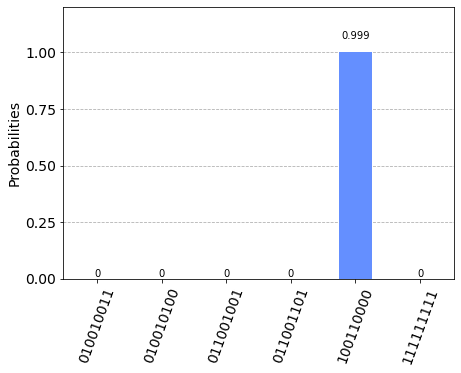

In [23]:
result = execute(qc, backend, shots = 8192).result()
counts = result.get_counts()
plot_histogram(counts)